<a href="https://colab.research.google.com/github/kairamilanifitria/NLP-Projects/blob/main/Project%203%20Voice%20Recognition/P3_Classifier_en.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Splitting

In [ ]:
!pip install transformers[torch]
!pip install accelerate -U
!pip install datasets[audio]
!pip install evaluate
!pip install jiwer
!pip install datasets --upgrade
!pip install rouge

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 333.2/333.2 kB 9.8 MB/s eta 0:00:00
  Attempting uninstall: accelerate
    Found existing installation: accelerate 0.34.2
    Uninstalling accelerate-0.34.2:
      Successfully uninstalled accelerate-0.34.2


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 28.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 17.4 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.
^C
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 3.3 MB/s eta 0:00:00


In [2]:
import numpy as np
import IPython.display as ipd
import torch
import transformers
import datasets
import librosa
import re
import json
import random
import matplotlib.pyplot as plt
import pandas as pd
import evaluate
import nltk
import librosa.display
from bs4 import BeautifulSoup
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

from IPython.display import display as ipd
from IPython.display import HTML
from datasets import load_dataset, ClassLabel, Audio # Remove load_metric from here
from evaluate import load # Import load from evaluate instead
from transformers import WhisperConfig, WhisperProcessor, WhisperFeatureExtractor, WhisperTokenizer, WhisperForConditionalGeneration
from transformers import Trainer, TrainingArguments, DataCollatorWithPadding, DataCollator
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments, Trainer, TrainingArguments
from transformers import pipeline
from transformers.utils import send_example_telemetry

from dataclasses import dataclass, field
from typing import Any, Dict, List, Optional, Union
from transformers import AdamW
from datasets import DatasetDict
from datasets import concatenate_datasets

from rouge import Rouge

nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [3]:
!huggingface-cli download PolyAI/minds14 --repo-type dataset --revision refs/convert/parquet --local-dir . --local-dir-use-symlinks False  --include 'en-US/*'
!huggingface-cli download PolyAI/minds14 --repo-type dataset --revision refs/convert/parquet --local-dir . --local-dir-use-symlinks False  --include 'en-AU/*'
!huggingface-cli download PolyAI/minds14 --repo-type dataset --revision refs/convert/parquet --local-dir . --local-dir-use-symlinks False  --include 'en-GB/*'

minds_enUS = load_dataset('./en-US', split="train")
minds_enAU = load_dataset('./en-AU', split="train")
minds_enGB = load_dataset('./en-GB', split="train")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/commands/download.py:132: FutureWarning: Ignoring --local-dir-use-symlinks. Downloading to a local directory does not use symlinks anymore.
  warnings.warn(
Fetching 1 files:   0% 0/1 [00:00<?, ?it/s]Downloading 'en-US/train/0000.parquet' to '.cache/huggingface/download/en-US/train/0000.parquet.07f4309eeb2eaec72b31960d6408544b17a4a08d8c49ad41f2b6f2c79962108b.incomplete'

0000.parquet:   0% 0.00/34.2M [00:00<?, ?B/s]
0000.parquet:  31% 10.5M/34.2M [00:00<00:00, 25.4MB/s]
0000.parquet:  61% 21.0M/34.2M [00:00<00:00, 44.6MB/s]
0000.parquet: 100% 34.2M/34.2M [00:00<00:00, 36.6MB/s]
Download complete. Moving file to en-US/train/0000.parquet
Fetching 1 files: 100% 1/1 [00:01<00:00,  1.39s/it]
/content
/usr/local/lib/python3.10/dist-packages/huggingface_hub/commands/download.py:132: FutureWarning: Ignoring --local-dir-use-symlinks. Downloading to a local directory does not use symlinks anymore.
  warnings.warn(
Fetching 1 files:   0% 0/1

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

In [4]:
print(minds_enUS)
print(minds_enAU)
print(minds_enGB)

Dataset({
    features: ['path', 'audio', 'transcription', 'english_transcription', 'intent_class', 'lang_id'],
    num_rows: 563
})
Dataset({
    features: ['path', 'audio', 'transcription', 'english_transcription', 'intent_class', 'lang_id'],
    num_rows: 654
})
Dataset({
    features: ['path', 'audio', 'transcription', 'english_transcription', 'intent_class', 'lang_id'],
    num_rows: 592
})


In [5]:
merged_dataset = concatenate_datasets([minds_enUS, minds_enAU, minds_enGB])

print(merged_dataset)

Dataset({
    features: ['path', 'audio', 'transcription', 'english_transcription', 'intent_class', 'lang_id'],
    num_rows: 1809
})


In [6]:
intent_classes = [
    {'index': 0, 'name': 'abroad'},
    {'index': 1, 'name': 'adress'},
    {'index': 2, 'name': 'app_error'},
    {'index': 3, 'name': 'atm_limit'},
    {'index': 4, 'name': 'balance'},
    {'index': 5, 'name': 'business_loan'},
    {'index': 6, 'name': 'card_issues'},
    {'index': 7, 'name': 'cash_deposite'},
    {'index': 8, 'name': 'direct_debit'},
    {'index': 9, 'name': 'freeze'},
    {'index': 10, 'name': 'latest_transactions'},
    {'index': 11, 'name': 'joint_account'},
    {'index': 12, 'name': 'high_value_payment'},
    {'index': 13, 'name': 'pay_bill'}
]

In [7]:
def count_feature_lengths(dataset):
    feature_lengths = {}

    for feature in dataset.features:
        values = dataset[feature]
        lengths = [len(str(value)) if not isinstance(value, (int, float, dict, list)) else 1 for value in values]
        feature_lengths[feature] = lengths
    return feature_lengths

feature_lengths = count_feature_lengths(merged_dataset)

for feature, lengths in feature_lengths.items():
    print(f"{feature}: {len(lengths)}")

path: 1809
audio: 1809
transcription: 1809
english_transcription: 1809
intent_class: 1809
lang_id: 1809


In [11]:
feature_lengths = count_feature_lengths(minds_enUS)

for feature, lengths in feature_lengths.items():
    print(f"{feature}: {len(lengths)}")

path: 563
audio: 563
transcription: 563
english_transcription: 563
intent_class: 563
lang_id: 563


In [12]:
def remove_columns(example):
  del example["english_transcription"]
  del example["lang_id"]
  del example["path"]
  del example["audio"]
  return example

dataset = merged_dataset.map(remove_columns)

dataset

Map:   0%|          | 0/1809 [00:00<?, ? examples/s]

Dataset({
    features: ['transcription', 'intent_class'],
    num_rows: 1809
})

In [14]:
dataset[1500]

{'transcription': 'hi there I was just calling regards to setting up a joint account and just wondering how they would do that if I come into the store or if I could do that on the app trying to get that for me thank you',
 'intent_class': 11}

In [15]:
df = pd.DataFrame(dataset)

train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

In [16]:
test_df

,transcription,intent_class
1370,I've recently moved addresses and I need to up...,1
65,I'm wondering if I could find out what my acco...,4
1289,please block my card,9
941,will my cotton work and I was wondering why I ...,6
1067,I am calling about a recent transaction,12
...,...,...
1696,I've just had a text and I don't recognise som...,12
416,I'd like to make a kind of large payment,10
1037,my last transaction,12
705,I need to get money out tomorrow and I'm just ...,3


In [17]:
test_df.to_csv('test.csv', index=False)
from google.colab import files
files.download('test.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [18]:
train_df

,transcription,intent_class
1391,I'm just ringing to ask it what is the actual ...,3
1463,card board can I pay for things when I'm in Am...,0
839,yes I would like to open a joint account,11
772,ID like to change my address,1
394,why do I keep getting these text messages I ju...,10
...,...,...
1130,and wanting to make a payment of a large amoun...,10
1294,will you think as an application for my bankin...,2
860,how do I set up a joint account,11
1459,can I pay for things when I'm in America,0


In [19]:
train_df.to_csv('train.csv', index=False)
from google.colab import files
files.download('train.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Load Dataset

In [1]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import numpy as np
import pandas as pd
import torch

In [2]:
def load_data(train_path, test_path):
    train_df = pd.read_csv("/content/train_2.csv")
    test_df = pd.read_csv("/content/test_2.csv")

    # Convert 'intent_class' to integer labels
    train_df['label'] = train_df['intent_class'].apply(lambda x: int(x))
    test_df['label'] = test_df['intent_class'].apply(lambda x: int(x))

    # Create Dataset objects
    train_dataset = Dataset.from_pandas(train_df[['transcription', 'label']])
    test_dataset = Dataset.from_pandas(test_df[['transcription', 'label']])
    return train_dataset, test_dataset

In [3]:
# Set your dataset paths
train_path = "/content/train_2.csv"
test_path = "/content/test_2.csv"
train_dataset, test_dataset = load_data(train_path, test_path)

In [10]:
# Load RoBERTa tokenizer and model
model_name = "roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=14)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [11]:
# Tokenize the data
def tokenize_function(examples):
    return tokenizer(examples["transcription"], padding="max_length", truncation=True)

tokenized_train = train_dataset.map(tokenize_function, batched=True)
tokenized_test = test_dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/1447 [00:00<?, ? examples/s]

Map:   0%|          | 0/362 [00:00<?, ? examples/s]

In [12]:
# Define the evaluation metric
def compute_metrics(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=1)
    accuracy = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average="weighted")
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

In [13]:
# Training arguments
training_args = TrainingArguments(
    output_dir="./results",
    overwrite_output_dir=True,             # Ensures no conflicts with previous runs
    evaluation_strategy="steps",
    save_steps=500,
    eval_steps=500,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=20,                    # Adjust epochs as needed
    learning_rate=2e-5,                    # Recommended starting LR for roberta-base
    weight_decay=0.01,
    warmup_steps=500,
    max_grad_norm=1.0,
    gradient_accumulation_steps=2,
    logging_dir='./logs',
    logging_steps=100,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [14]:
# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    compute_metrics=compute_metrics
)

In [9]:
import wandb
wandb.init(mode="disabled")

In [15]:
# Train the model
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
500,0.023000,0.091624,0.972376,0.973572,0.972376,0.972401


TrainOutput(global_step=900, training_loss=0.5090014420946439, metrics={'train_runtime': 2557.3696, 'train_samples_per_second': 11.316, 'train_steps_per_second': 0.352, 'total_flos': 7533417990703104.0, 'train_loss': 0.5090014420946439, 'epoch': 19.78021978021978})

In [17]:
# Define the local path where you want to save the model
model_save_path = "./RoBERTa-mind14-classifier-intent"

# Save the trained model
model.save_pretrained(model_save_path)

# Save the tokenizer
tokenizer.save_pretrained(model_save_path)

print(f"Model and tokenizer saved locally to {model_save_path}")


Model and tokenizer saved locally to ./RoBERTa-mind14-classifier-intent


In [18]:
eval_result = trainer.evaluate()
print("Evaluation Results:", eval_result)

Evaluation Results: {'eval_loss': 0.09162407368421555, 'eval_accuracy': 0.9723756906077348, 'eval_precision': 0.9735716601697026, 'eval_recall': 0.9723756906077348, 'eval_f1': 0.9724008148743496, 'eval_runtime': 10.9366, 'eval_samples_per_second': 33.1, 'eval_steps_per_second': 2.103, 'epoch': 19.78021978021978}


In [19]:
# Detailed evaluation
def detailed_evaluation(trainer, test_dataset):
    # Predict on the test set
    preds_output = trainer.predict(test_dataset)
    preds = np.argmax(preds_output.predictions, axis=1)
    labels = preds_output.label_ids

    # Confusion matrix
    conf_matrix = confusion_matrix(labels, preds)
    print("Confusion Matrix:\n", conf_matrix)

    # Classification report
    accuracy = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average="weighted")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

# Run detailed evaluation
detailed_evaluation(trainer, tokenized_test)

Confusion Matrix:
 [[25  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 26  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0 21  0  0  0  2  0  0  0  0  0  0  0]
 [ 0  0  0 34  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0 27  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0 27  0  0  0  0  0  1  0  0]
 [ 0  0  0  0  0  0 26  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0 25  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0 21  0  0  0  1  0]
 [ 1  0  0  0  0  0  0  0  0 25  0  0  0  0]
 [ 0  0  0  0  0  0  0  1  0  0 31  0  0  1]
 [ 0  0  0  0  0  0  0  0  0  0  0 20  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  1  0 20  1]
 [ 0  0  0  0  0  0  1  0  0  0  0  0  0 24]]
Accuracy: 0.9724
Precision: 0.9736
Recall: 0.9724
F1 Score: 0.9724


Confusion Matrix:
 [[25  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 26  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0 21  0  0  0  2  0  0  0  0  0  0  0]
 [ 0  0  0 34  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0 27  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0 27  0  0  0  0  0  1  0  0]
 [ 0  0  0  0  0  0 26  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0 25  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0 21  0  0  0  1  0]
 [ 1  0  0  0  0  0  0  0  0 25  0  0  0  0]
 [ 0  0  0  0  0  0  0  1  0  0 31  0  0  1]
 [ 0  0  0  0  0  0  0  0  0  0  0 20  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  1  0 20  1]
 [ 0  0  0  0  0  0  1  0  0  0  0  0  0 24]]
Accuracy: 0.9724
Precision: 0.9736
Recall: 0.9724
F1 Score: 0.9724


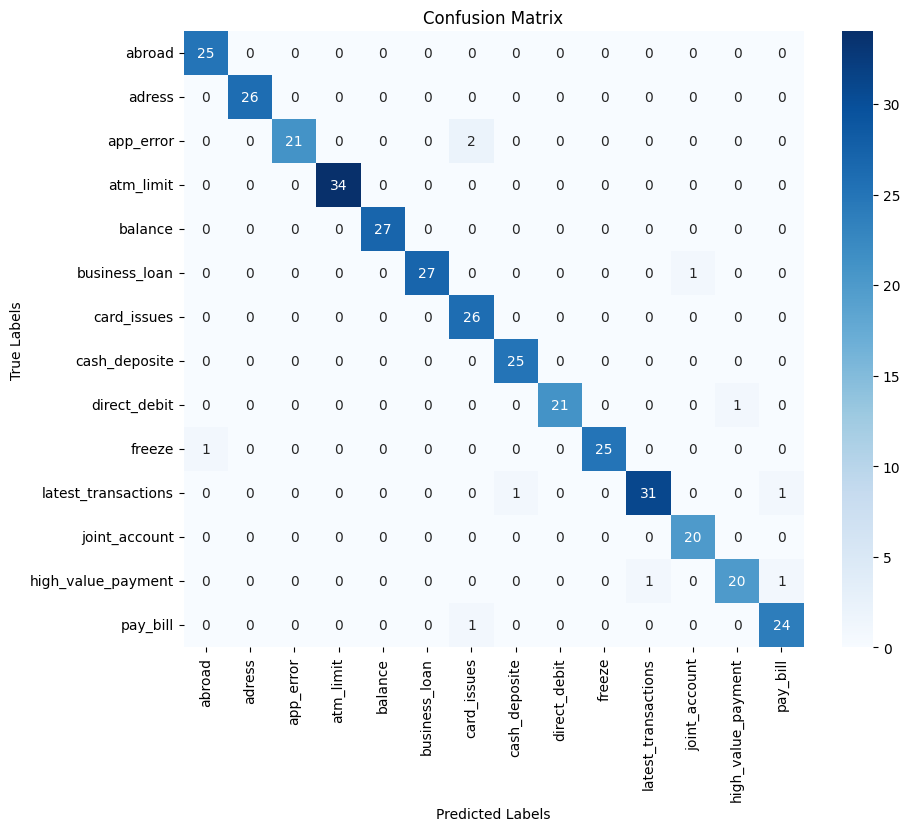

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import numpy as np

# Assuming intent_classes is a list of dictionaries,
# each dictionary having a 'name' key for the intent name
# Replace this with your actual intent_classes definition:
intent_classes = [
    {'index': 0, 'name': 'abroad'},
    {'index': 1, 'name': 'adress'},
    {'index': 2, 'name': 'app_error'},
    {'index': 3, 'name': 'atm_limit'},
    {'index': 4, 'name': 'balance'},
    {'index': 5, 'name': 'business_loan'},
    {'index': 6, 'name': 'card_issues'},
    {'index': 7, 'name': 'cash_deposite'},
    {'index': 8, 'name': 'direct_debit'},
    {'index': 9, 'name': 'freeze'},
    {'index': 10, 'name': 'latest_transactions'},
    {'index': 11, 'name': 'joint_account'},
    {'index': 12, 'name': 'high_value_payment'},
    {'index': 13, 'name': 'pay_bill'}
]

def detailed_evaluation(trainer, test_dataset):
    # Predict on the test set
    preds_output = trainer.predict(test_dataset)
    preds = np.argmax(preds_output.predictions, axis=1)
    labels = preds_output.label_ids

    # Confusion matrix
    conf_matrix = confusion_matrix(labels, preds)  # This line calculates conf_matrix
    print("Confusion Matrix:\n", conf_matrix)

    # Classification report
    accuracy = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average="weighted")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

    # Confusion matrix visualization
    plt.figure(figsize=(10, 8))
    # Now conf_matrix is accessible here within the same function
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
                xticklabels= [i['name'] for i in intent_classes],
                yticklabels=[i['name'] for i in intent_classes])
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix")
    plt.show()

# Run detailed evaluation
detailed_evaluation(trainer, tokenized_test)

In [ ]:
# prompt: download the /content/RoBERTa-mind14-classifier-intent into my local computer

from google.colab import files

# Replace with the actual path to your saved model directory
saved_model_pt = "/content/RoBERTa-mind14-classifier-intent"

# Create a zip file of the model directory
!zip -r {saved_model_pt}.zip {saved_model_pt}

# Download the zip file
files.download(f'{saved_model_pt}.zip')

In [21]:
from transformers import pipeline

model = "/content/RoBERTa-mind14-classifier-intent"

# Load the saved model
classifier = pipeline("text-classification", model=model)

# Example prediction
text = "hi what's the maximum amount of money I can withdraw from" # Replace with your desired input text
prediction = classifier(text)
prediction

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


[{'label': 'LABEL_3', 'score': 0.9933607578277588}]